### Урок 5. Кейс 1. Аномалии и артефакты#

### -- Автор: Шенк Евгений Станиславович

###  Задание 1-2-3-4-5
1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями  
2. Добавьте первые разности по стоимости доллара и евро к рублю  
3. сделайте ее перрасчет (ресемплинг) в представление по неделям.   
4. Постройте модель предсказания 1-й точки от текущей (h=1).  

5. Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.  

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd 
import seaborn as sns
import pandas_profiling
import datetime
import itertools
import lightgbm as lgbm
import scipy

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
import scipy.stats as scs

from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

import os

from fbprophet import Prophet

import warnings
warnings.filterwarnings("ignore") # отключает предупреждения

In [2]:
# Фукция для выявления важных признаков при работе lightGBM
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [3]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [4]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
def split_data_b(data, split_date):
    return data.loc[data.index <= split_date].copy(), \
           data.loc[data.index >  split_date].copy()

In [6]:
data = pd.read_csv('my_BRENT2019.csv', index_col=[0], parse_dates=[0])

In [7]:
data['diff1'] = 0.0
data['diff1'].iloc[1:] = data['Значение'].iloc[:-1].values - data['Значение'].iloc[1:].values
data.drop(columns={'Значение'}, inplace=True)

In [8]:
data.head(3)

,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,diff1
Дата,,,,,,,,,,,
2010-09-01,2010,9,1,3,244,35,2,0,0,0,0.00
2010-09-02,2010,9,2,3,245,35,3,0,0,0,-0.52
2010-09-03,2010,9,3,3,246,35,4,0,0,0,0.32


Text(0, 0.5, '$')

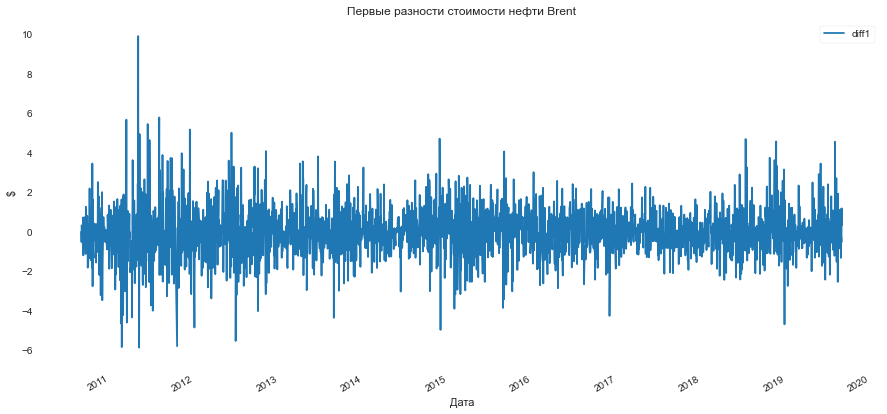

In [9]:
data['diff1'].plot(figsize = ( 15, 7 ), title = 'Первые разности стоимости нефти Brent' )
plt.legend()
plt.ylabel ('$')

In [10]:
sm.tsa.stattools.adfuller(data['diff1'],regression='ct')

(-54.99045993757404,
 0.0,
 0,
 2666,
 {'1%': -3.962169768207342,
  '5%': -3.4121380854205725,
  '10%': -3.128020395870901},
 8615.247921501536)

### -> Ряд стационарен

### Добавляем разности курсов валют

In [11]:
data_usd = pd.read_excel('RC_F01_09_2010_T01_09_2019_USD.xlsx')
data_usd.index = pd.to_datetime(data_usd['data'].values).date
data_usd.drop(['nominal','cdx','data'], axis=1,inplace = True)
data_usd['diff1_usd'] = 0.0
data_usd['diff1_usd'].iloc[1:] = data_usd['curs'].iloc[:-1].values - data_usd['curs'].iloc[1:].values
data_usd.head(3)

,curs,diff1_usd
2010-09-01,30.8669,0.0000
2010-09-02,30.8001,0.0668
2010-09-03,30.6858,0.1143


In [12]:
data_eur = pd.read_excel('RC_F01_09_2010_T01_09_2019_EUR.xlsx')
data_eur.index = pd.to_datetime(data_eur['data'].values).date
data_eur.drop(['nominal','cdx','data'], axis=1,inplace = True)
data_eur['diff1_eur'] = 0.0
data_eur['diff1_eur'].iloc[1:] = data_eur['curs'].iloc[:-1].values - data_eur['curs'].iloc[1:].values
data_eur.head(3)

,curs,diff1_eur
2010-09-01,39.0127,0.0000
2010-09-02,39.1654,-0.1527
2010-09-03,39.2901,-0.1247


In [13]:
sm.tsa.stattools.adfuller(data_usd['diff1_usd'],regression='ct')[1]

3.9269168321947575e-08

In [14]:
sm.tsa.stattools.adfuller(data_eur['diff1_eur'],regression='ct')[1]

6.836437816085617e-11

### Тоже стационарные ряды

In [15]:
data_merged = pd.merge(data_eur, data_usd, how ='left', left_index=True, right_index=True)
data_merged = data_merged.drop(columns=['curs_x', 'curs_y'])

In [16]:
data_curr = pd.merge(data, data_merged, how ='left', left_index=True, right_index=True)

#### ресемплинг в представление по неделям

In [17]:
data_W = data_curr.resample("W").mean().interpolate(method='linear')
data_W.head(3)

,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,diff1,diff1_eur,diff1_usd
Дата,,,,,,,,,,,,,
2010-09-05,2010.0,9.0,3.000000,3.0,246.000000,35.0,4.000000,0.000000,0.2,0.000000,-0.052000,-0.084450,0.043675
2010-09-12,2010.0,9.0,8.500000,3.0,251.500000,36.0,2.500000,0.166667,0.0,0.166667,-0.288333,0.031760,-0.040300
2010-09-19,2010.0,9.0,15.666667,3.0,258.666667,37.0,2.666667,0.000000,0.0,0.000000,0.021667,-0.281225,-0.032150


In [18]:
# Убираем неинформативные признаки
data_W.drop(columns=['dayofweek'], inplace=True)

In [19]:
# добавили историю на глубину p измерения от текущего
p=7

for x in range(1, p+1):
    data_W[f't{x}'] = 0.0
    data_W[f't{x}'].iloc[x:]=data_W['diff1'].iloc[:-x].values
    data_W[f'eur_t{x}'] = 0.0
    data_W[f'eur_t{x}'].iloc[x:]=data_W['diff1_eur'].iloc[:-x].values
    data_W[f'usd_t{x}'] = 0.0
    data_W[f'usd_t{x}'].iloc[x:]=data_W['diff1_usd'].iloc[:-x].values

data_W.fillna(0, inplace=True)

In [20]:
# Добавляем признаки методом главных компонент
scl=StandardScaler()
Xscale = scl.fit_transform(data_W.iloc[:,:-1].values)
pca = PCA(n_components=2, svd_solver='full')
Xpca=pca.fit_transform(Xscale[:,1:])

data_W['pca1'] = 0
data_W['pca1'] = Xpca[:,0]
data_W['pca1'] = 0
data_W['pca2'] = Xpca[:,1]

In [21]:
h=1
scl_x=StandardScaler() 
X = data_W.iloc[p:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))

scl_target=StandardScaler() 
target = data_W['diff1'].values[h+p:].reshape((data_W.shape[0]-h-p,1))
y = scl_target.fit_transform(target)

In [22]:
sfk =SelectKBest(f_regression, k=5)
X_new1 =sfk.fit_transform(X, y.ravel())
column_names = data_W.columns[sfk.get_support()]
column_names

Index(['month', 'quarter', 'dayofyear', 'weekofyear', 't5'], dtype='object')

In [23]:
sfp=SelectPercentile(f_regression, percentile=20)
X_new2 = sfp.fit_transform(X, y.ravel())
column_namesp = data_W.columns[sfp.get_support()]
column_namesp

Index(['month', 'quarter', 'dayofyear', 'weekofyear', 'eur_t3', 'usd_t3',
       't5'],
      dtype='object')

In [24]:
model_lgbm = lgbm.LGBMRegressor(learning_rate = 0.01,
                                num_leaves=7, 
                                n_estimators = 1000,
                                subsample = 1,
                                reg_alpha = 5,
                                reg_lambda = 5,
                                n_jobs = -1,
                                random_state = 21)

In [25]:
model_lgbm.fit(X, y) 
Y_pred_gb = model_lgbm.predict(X)

er_r2 = r2_score(y_true=y, y_pred=Y_pred_gb)

print('r2 score :  ', er_r2, '%')

r2 score :   0.5671389203095591 %


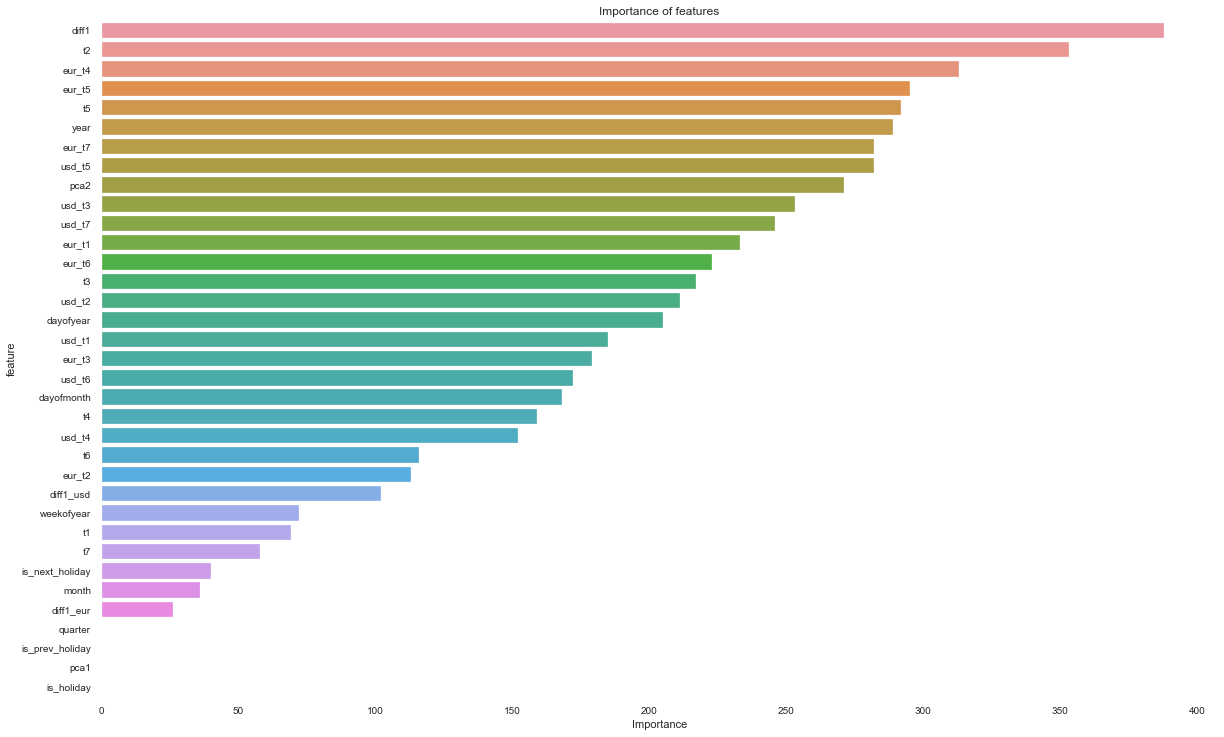

In [26]:
important_features_lgbm = show_feature_importances(data_W.columns, model_lgbm.feature_importances_, get_top=9)

In [27]:
# Получаем список важных признаков
important_features_total = list(set(important_features_lgbm + list(column_namesp) + ['diff1']))

### Построим различные модели
### LightGBM
### SARIMAX
### FBProphet

In [28]:
train_b, test_b = split_data_b(data_W[important_features_total], '31/12/2017')

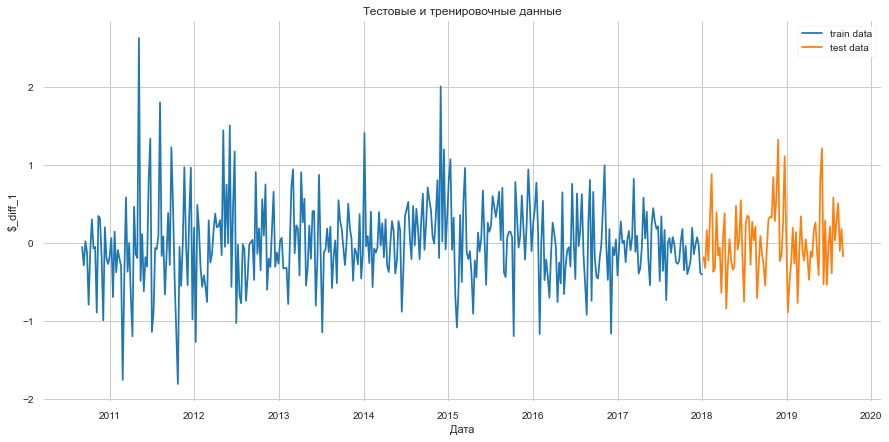

In [29]:
X_train_b = train_b.iloc[:-1,:]
y_train_b = train_b['diff1'].values[1:]
X_test_b = test_b.iloc[:-1,:]
y_test_b = test_b['diff1'].values[1:]

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Дата')
plt.ylabel('$_diff_1')
plt.plot(train_b.index.get_level_values('Дата'), train_b['diff1'], label='train data' )
plt.plot(test_b.index.get_level_values('Дата'), test_b['diff1'], label='test data')

plt.title('Тестовые и тренировочные данные')
plt.legend()
plt.grid()
plt.show()

### LightGBM

In [30]:
model_lgbm = lgbm.LGBMRegressor(learning_rate = 0.01,
                                num_leaves=5, 
                                n_estimators = 500,
                                subsample = 1,
                                reg_alpha = 5,
                                reg_lambda = 5,
                                n_jobs = -1,
                                random_state = 21)

In [31]:
"""params = {'n_estimators':[250, 400, 500, 750], 
          'num_leaves':[1, 2, 3, 4, 5, 6,],
          'learning_rate':[0.01],
          'reg_alpha':[0, 5, 10, 20],
          'reg_lambda':[0, 5, 10, 20]}

cv=KFold(n_splits=2, random_state=21, shuffle=True)

rs = GridSearchCV(model_lgbm, params, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
rs.fit(X_train_b, y_train_b)"""

"params = {'n_estimators':[250, 400, 500, 750], \n          'num_leaves':[1, 2, 3, 4, 5, 6,],\n          'learning_rate':[0.01],\n          'reg_alpha':[0, 5, 10, 20],\n          'reg_lambda':[0, 5, 10, 20]}\n\ncv=KFold(n_splits=2, random_state=21, shuffle=True)\n\nrs = GridSearchCV(model_lgbm, params, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)\nrs.fit(X_train_b, y_train_b)"

In [32]:
"""rs.best_params_"""

'rs.best_params_'

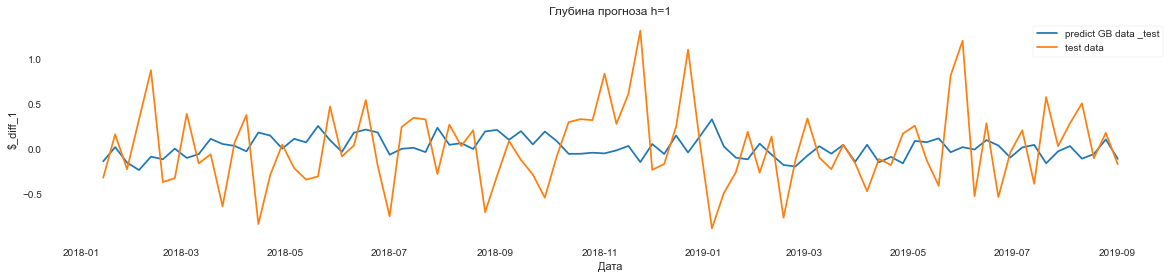

ошибка градиентного бустинга :   110.76394662852562 %
r2 score :   -0.21945072654239595


In [33]:
h_list = [1]

for h in h_list:
    X_train_b = train_b.iloc[p:-h,:]
    y_train_b = train_b['diff1'].values[h+p:]
    X_test_b = test_b.iloc[:-h,:]
    y_test_b = test_b['diff1'].values[h:]

    model_lgbm.fit( X_train_b, y_train_b ) 
    Y_test_pred_gb = model_lgbm.predict(X_test_b)
    Y_train_pred_gb = model_lgbm.predict(X_train_b)

    plt.figure( figsize=( 20, 4 ))

    plt.title(f'Глубина прогноза h={h}')
    plt.xlabel('Дата')
    plt.ylabel('$_diff_1')
    plt.plot(test_b.index[h:], Y_test_pred_gb, label='predict GB data _test' )
    plt.plot(test_b.index[h:], y_test_b, label='test data')
    
    #plt.plot(train_b.index[h+p:], Y_train_pred_gb, label='predict GB data _train')
    
    #plt.plot(data_W.loc[:'01/01/2018'].index, data_W.loc[:'01/01/2018']['diff1'], label='исходный ряд')
    
    plt.legend()
    plt.show()

    er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=Y_test_pred_gb)
    er_r2 = r2_score(y_true=y_test_b, y_pred=Y_test_pred_gb)

    print('ошибка градиентного бустинга :  ', er_g, '%')
    print('r2 score :  ', er_r2)

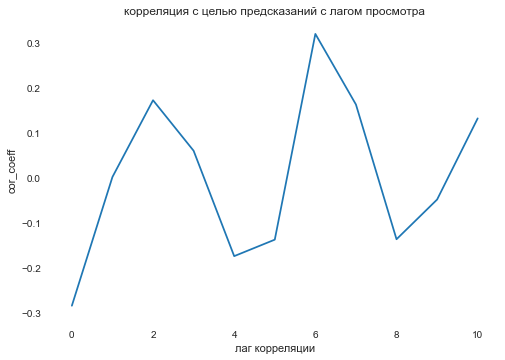

In [34]:
lag=10
p_cor=[np.corrcoef( y_test_b, Y_test_pred_gb)[1,0]]
for i in range(lag):
    c=np.corrcoef( y_test_b[:-(i+1)], Y_test_pred_gb[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) ) 
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция с целью предсказаний с лагом просмотра')
plt.show()

### Градиентный бустинг в данном случае получил плохой результат

### SARIMAX

In [35]:
data_w = data_W[important_features_total]

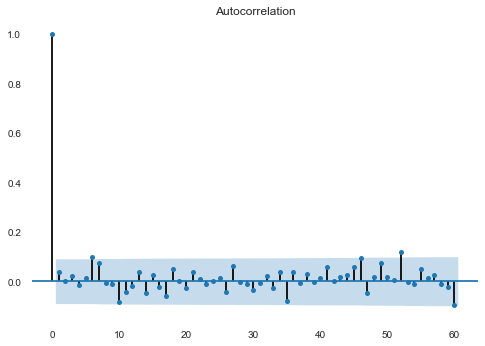

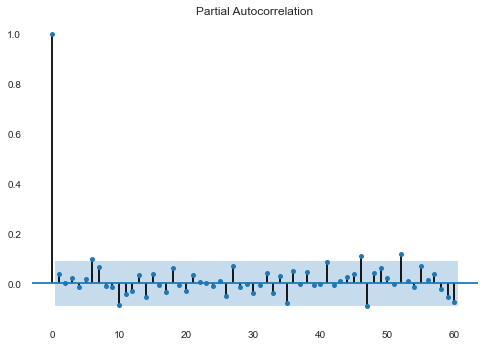

In [36]:
sm.graphics.tsa.plot_acf(data_W['diff1'].values, lags=60)
plt.show()

sm.graphics.tsa.plot_pacf(data_W['diff1'].values, lags=60)
plt.show()

In [37]:
# Определим p, d и q 
q = range(0, 3)
p = range(0, 3)
d = range(0, 2)
pdq = list(itertools.product(p, d, q))
param_seasonal = [0, 0, 0, 0] # нет сезона

In [38]:
N1 = 0     # берем дданные не от начала
N2 = 12    # число точек для теста
for param in pdq:
    try:
        model = sm.tsa.statespace.SARIMAX(data_W['diff1'].values[N1:-N2],
                                          order=param,
                                          seasonal_order=param_seasonal,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)

        results = model.fit()
        print('ARIMA{}x{}3 - AIC:{}'.format(param, param_seasonal, results.aic))
    except:
        continue

ARIMA(0, 0, 0)x[0, 0, 0, 0]3 - AIC:698.481487012894
ARIMA(0, 0, 1)x[0, 0, 0, 0]3 - AIC:698.8403690195299
ARIMA(0, 0, 2)x[0, 0, 0, 0]3 - AIC:700.2922885606375
ARIMA(0, 1, 0)x[0, 0, 0, 0]3 - AIC:993.9116888834515
ARIMA(0, 1, 1)x[0, 0, 0, 0]3 - AIC:703.9468928142539
ARIMA(0, 1, 2)x[0, 0, 0, 0]3 - AIC:704.8206124045889
ARIMA(1, 0, 0)x[0, 0, 0, 0]3 - AIC:699.6803555667855
ARIMA(1, 0, 1)x[0, 0, 0, 0]3 - AIC:700.8308200667582
ARIMA(1, 0, 2)x[0, 0, 0, 0]3 - AIC:702.2919079112291
ARIMA(1, 1, 0)x[0, 0, 0, 0]3 - AIC:879.0304436009709
ARIMA(1, 1, 1)x[0, 0, 0, 0]3 - AIC:705.4454365311417
ARIMA(1, 1, 2)x[0, 0, 0, 0]3 - AIC:706.3904105551308
ARIMA(2, 0, 0)x[0, 0, 0, 0]3 - AIC:700.8309858806979
ARIMA(2, 0, 1)x[0, 0, 0, 0]3 - AIC:702.9297767977871
ARIMA(2, 0, 2)x[0, 0, 0, 0]3 - AIC:702.77420843538
ARIMA(2, 1, 0)x[0, 0, 0, 0]3 - AIC:823.4944974649873
ARIMA(2, 1, 1)x[0, 0, 0, 0]3 - AIC:708.0266356881754
ARIMA(2, 1, 2)x[0, 0, 0, 0]3 - AIC:708.2531592182778


In [39]:
# ARIMA(0, 0, 0)x[0, 0, 0, 0]3 - AIC:698.481487012894
param = [0, 0, 0]
param_seasonal = [0, 0, 0, 0] # нет сезона
model = sm.tsa.statespace.SARIMAX(data_W['diff1'].values[N1:-N2],
                                  order=param,
                                  seasonal_order=param_seasonal,
                                  trend='ct',
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
result_data_W = model.fit()
print(result_data_W.summary().tables[0], result_data_W.summary().tables[1])

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  458
Model:                        SARIMAX   Log Likelihood                -347.908
Date:                Sat, 27 Jun 2020   AIC                            701.817
Time:                        20:23:44   BIC                            714.191
Sample:                             0   HQIC                           706.691
                                - 458                                         
Covariance Type:                  opg                                         
============================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0357      0.042     -0.843      0.3

### Не видно не сезона не тренда

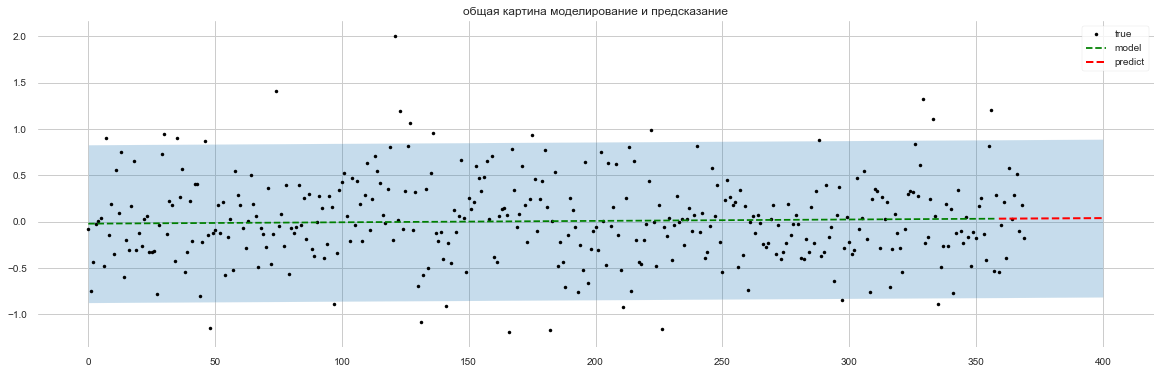

In [40]:
N1 = 0
N2 = 12 
N3 = 100  # отступ данных для отображения  модели (для улучшения визуальных качеств рисунка - берем из интервала [0-500])
nforecast = N2+30  # общее число точек для предсказания (N2 - тестовых точек + точки для чистого предсказания)
predict_ = result_data_W.get_prediction(end = result_data_W.nobs + nforecast)   
# получаем результаты работы модели по всей выборке

# отображаем результаты
idx = np.arange(len(predict_.predicted_mean)-N3)
predict_ci = predict_.conf_int(alpha=0.1)

fig, ax = plt.subplots(figsize=(20,6))
ax.plot(data_W['diff1'].values[N3:], 'k.',label='true')
plt.grid()
ax.plot(idx[:-nforecast], predict_.predicted_mean[N3:-nforecast], '--g',label='model')
ax.plot(idx[-nforecast:], predict_.predicted_mean[-nforecast:], 'r--', linestyle='--', linewidth=2,label = 'predict')
ax.fill_between(idx, predict_ci[N3:, 0], predict_ci[N3:, 1], alpha=0.25)
plt.legend()

ax.set(title='общая картина моделирование и предсказание');

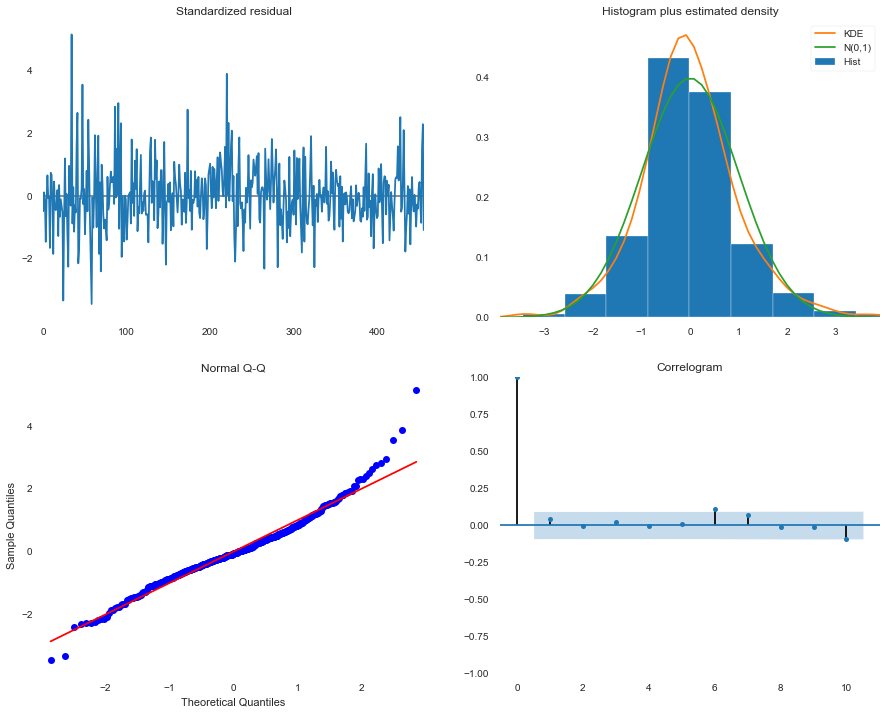

In [41]:
result_data_W.plot_diagnostics(figsize=(15, 12))
plt.show()

### Построение модели SARIMAX, автокорреляций и настройка пареметров показали отсутствие сезона/тренда, построеная модель подтверждает информацию о стационарности ряда, на графике можно увидеть диапазон значений с шансом 90%

### fbProphet

In [42]:
data_prop=data_W['diff1'].copy()
data_prop=data_prop.reset_index()
data_prop.columns=['ds','y']

data_prop.head(3)

,ds,y
0,2010-09-05,-0.052000
1,2010-09-12,-0.288333
2,2010-09-19,0.021667


In [43]:
data_prop.shape

(470, 2)

In [44]:
Prophet_model = Prophet( )
Prophet_model.fit(data_prop.iloc[:,:])

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [45]:
future = Prophet_model.make_future_dataframe(periods=100)
forecast = Prophet_model.predict(future)

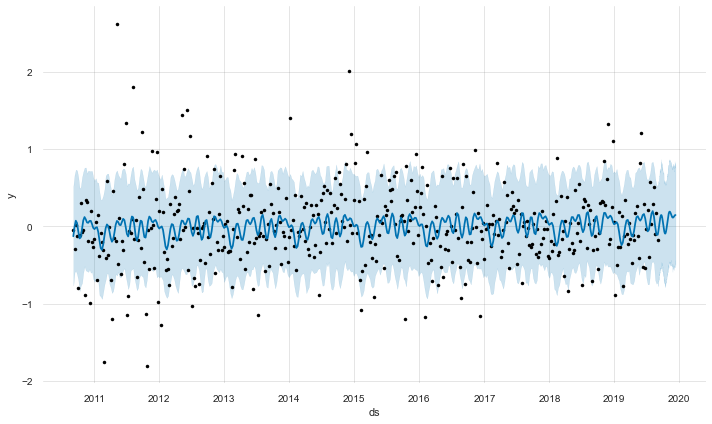

In [46]:
Prophet_model.plot(forecast)
plt.show()

### На модели fbProphet видна некоторая сезонность, что странно.

### Выводы:

### Модель SARIMAX получилась наиболее информативной и точной.

По сравнению с прямым предсказанием ряда бустинг так же не работает (в данном случае ограмная ошибка, а в прямом предсказании высокая корреляция с лагом, предсказание по вчерашнему дню), SARIMAX может прогнозировать значения модели в диапазоне дисперсии остатков (в прямом случае), который с дальностью предсказания портоянно расширяется. А в данном случае диапазон везде одинаков, что позволят получить одинаковый результат как для 1-й точки, татк и для n-ой.
Добавление первой разности курсов валют, никик не помогло постоению модели.